# Derivations with Miglio equations

In [1]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

import astropy.constants as const
import astropy.units as u

from astropy.visualization import quantity_support
quantity_support()

from ipywidgets import interact, IntSlider, FloatSlider

import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load and prep data

In [3]:
from importlib import reload
import sys
sys.path.append("../")

import mesagrid
reload(mesagrid);

sys.path.append("../helpers")
import mesaplot
reload(mesaplot);

In [4]:
usecols_history = ['model_number', 'star_age', 'log_Teff', 'log_L',
                   'center_h1', 'center_he4', 'star_mass']
cpus = 8

In [5]:
def get_timesteps(track, start, stop, step, mt_step, delay=0):
    h = track.history
    
    m = h["star_mass"]
    mt_start, mt_end = m[m > m.min()].index[0], m[m == m.max()].index[0]
    age_start = round(h["star_age"].loc[mt_start] / 1e6, 1)
    age_end = round(h["star_age"].loc[mt_end] / 1e6, 1)
    
    t_before = np.arange(start, np.floor(age_start), step)
    t_mt = np.arange(age_start, age_end + mt_step, mt_step)
    t_after = np.arange(np.ceil(age_end), stop + step, step)
    
    t = np.concatenate((t_before, t_mt, t_after))
    
    if delay > 0:
        t = np.concatenate((t, np.repeat(t[-1], delay)))
    return t

In [6]:
D_mix_pairs = [(3, 0.4), (3.508104, 0)]
D_mix_tracks = [mesagrid.Track(f"../output/mass_transfer_grid_with_D_mix/M_{M}-MT_{MT}/",
                       usecols_history=usecols_history,
                       cpus=cpus, parameters=f"M={M}, MT={MT}") for M, MT in D_mix_pairs]

In [7]:
def relevant_model_numbers(track):
    mt_start = track.history[track.history["star_mass"] > 3.0].index[0]
    mt_end = track.history[track.history["star_mass"] >= track.history["star_mass"].max()].index[0]
    
    print(f"Mass transfer starts at model {mt_start} and ends at {mt_end}")

In [8]:
def plot_period_spacing(age=None, X_c=None, mt_track=None, ref_track=None,
                        x_var="period", label_modes=False, xlims=None, ylims=None,
                        fig=None, ax=None, show=True):
    if age is None and X_c is None:
        raise ValueError("At least one of `age` or `X_c` must not be None")
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 3))
    plt.cla()
    

    if X_c is None:
        print(f"Plotting period spacing for age = {age:1.1f} Myr")
        acc_mod = np.abs(mt_track.history["star_age"] / 1e6 - age).argmin() if mt_track is not None else None
        non_acc_mod = np.abs(ref_track.history["star_age"] / 1e6 - age).argmin() if ref_track is not None else None
    else:
        print(f"Plotting period spacing for X_c = {X_c:1.2f}")
        acc_mod = np.abs(mt_track.history["center_h1"] - X_c).argmin() if mt_track is not None else None
        non_acc_mod = np.abs(ref_track.history["center_h1"] - X_c).argmin() if ref_track is not None else None
    
    print(acc_mod, non_acc_mod)
    
    for mod, track, tag, col in zip([acc_mod, non_acc_mod],
                                    [mt_track, ref_track],
                                    ["Mass-gainer", "Single"],
                                    [plt.get_cmap("magma")(0.3), plt.get_cmap("magma")(0.8)]):
        
        if track is None:
            continue

    # age = track.history.loc[profile_number - 1]["star_age"] / 1e6
    # X_c = track.history.loc[profile_number - 1]["center_h1"]
    # print(f"Age={age:1.2f} Myr")
        
        df = track.freqs[mod - 1]
        df = df[(df["l"] == 1) & (df["m"] == 0)]# & (df["n_p"] == 0)]
        mixed_modes = df[df["n_p"] > 0]
        duplicates = df[df["n_g"].isin(mixed_modes["n_g"])]
        drop_these = duplicates[duplicates["n_p"] == 0].index

        df = df.drop(index=drop_these)
                
        periods = 1 / df["Re(freq)"].values * u.day
        ng = df["n_g"].values
        delta_p  = periods[:-1] - periods[1:]

        x_vals = periods if x_var == "period" else -ng
    
        if label_modes:
            ax.plot(x_vals[:-1], delta_p, label=tag, color=col)
        else:
            ax.plot(x_vals[:-1], delta_p, marker="o", label=tag, color=col)

        if label_modes:
            for i in range(len(delta_p)):
                ax.annotate(ng[i], xy=(x_vals[i], delta_p[i]), ha="center", va="center",
                            fontsize=0.25*fs, color="grey",
                            bbox=dict(boxstyle="circle", facecolor="white", ec=col))

        aps = asymptotic_period_spacing(track.profiles[mod - 1]).to(u.day).value
        ax.axhline(aps, color=col, alpha=0.5, linestyle="dotted", zorder=-1)#, label=f"Expected asymptotic spacing ({tag})")

    ax.set_xlabel(r"Period, $P \, [\rm days]$" if x_var == "period" else r"$k$ (g-modes)")
    ax.set_ylabel(r"$\Delta P \, [\rm days]$")

    # ax.set_title(f"\nAge = {age:1.1f} Myr, X_c = {X_c:1.2f}", fontsize=0.6*fs)
    
    ax.set_title(r"Period spacing for final mass ~3.5 $\rm M_{\odot}$ star"\
                     + (f' at {age:1.1f} Myr' if X_c is None else r" with $X_c =$" + f' {X_c:1.2f}'))

    ax.annotate(r"$(l = 1, m = 0)$ g modes", xy=(0.02, 0.02), xycoords="axes fraction", va="bottom")

    if ylims is not None:
        if ylims == "auto":
            ax.set_ylim(aps - 0.04, aps + 0.04)
        else:
            ax.set_ylim(ylims)

    if xlims is not None:
        ax.set_xlim(xlims)

    ax.legend(loc="upper left", fontsize=0.5 * fs)
    
    if show:
        plt.show()

    return fig, ax, ng, periods

In [9]:
def find_closest_model_number(track, age=None, X_c=None):
    if age is None and X_c is None:
        raise ValueError("At least one of `age` or `X_c` must not be None")

    if X_c is None:
        mod = np.abs(track.history["star_age"] / 1e6 - age).argmin()
    else:
        mod = np.abs(track.history["center_h1"] - X_c).argmin()
        
    return mod

In [10]:
def asymptotic_period_spacing(p, unit=u.day):
    l = 1
    L = np.sqrt(l * (l + 1))
    
    p_sort = p.sort_values(by="logR")

    R = 10**(p_sort["logR"].values)
    r = R / np.max(R)
    N = p_sort["brunt_N"].values
    
    delta_P = 2 * np.pi**2 / (L * np.trapz(y=N / r, x=r)) * u.s
    return delta_P.to(unit)

Plotting period spacing for X_c = 0.68
33 47


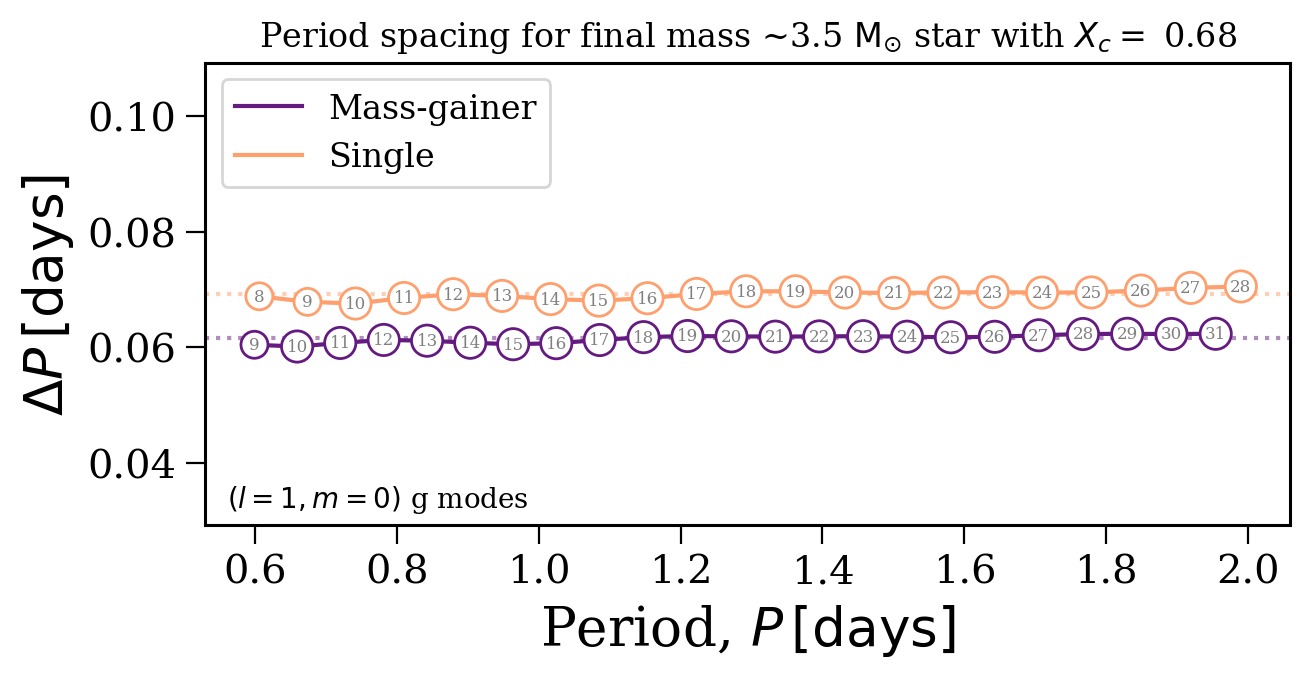

Plotting period spacing for X_c = 0.50
62 76


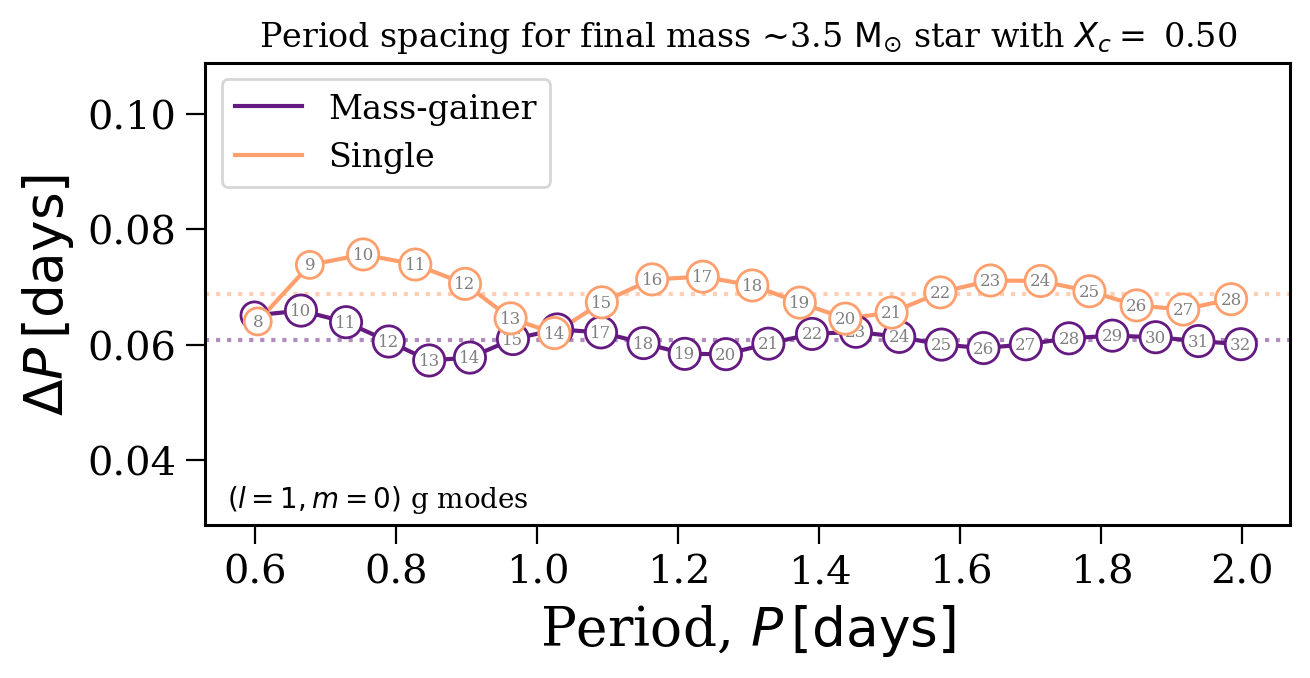

Plotting period spacing for X_c = 0.35
198 98


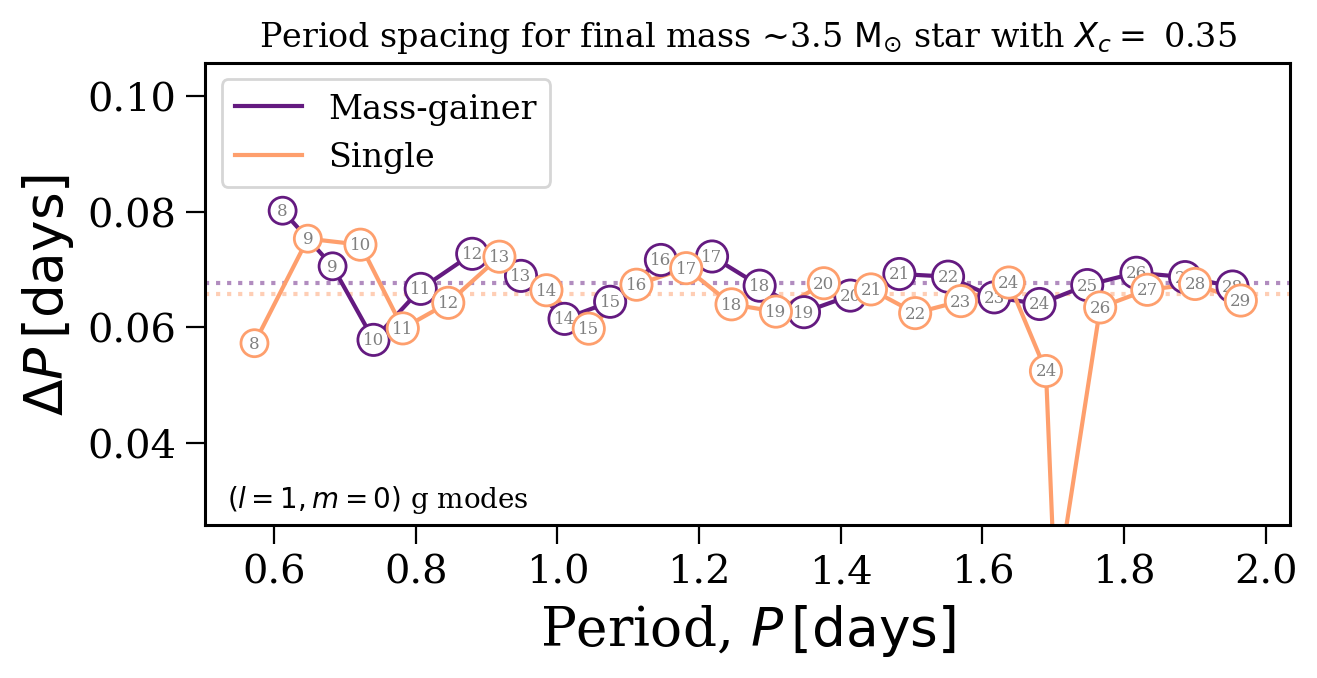

Plotting period spacing for X_c = 0.25
213 114


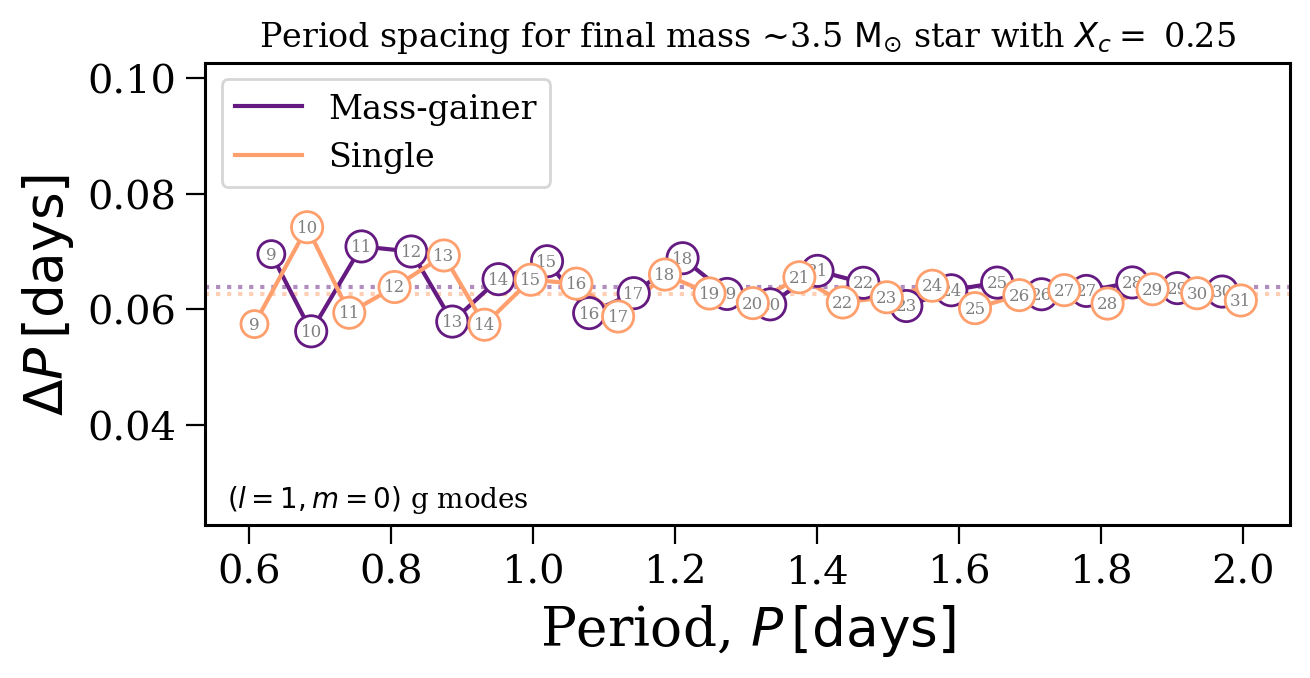

Plotting period spacing for X_c = 0.10
238 141


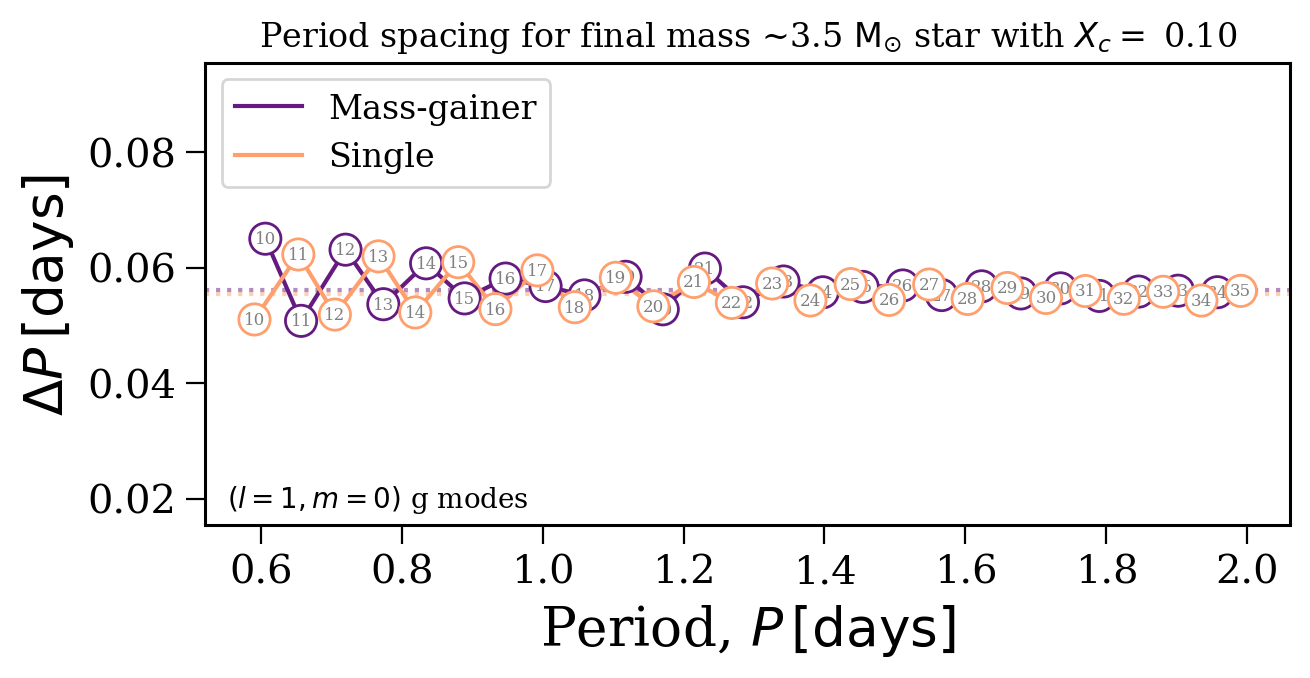

In [13]:
for X_c in [0.68, 0.5, 0.35, 0.25, 0.1]:
    plot_period_spacing(X_c=X_c, mt_track=D_mix_tracks[0], ref_track=D_mix_tracks[1],
                        ylims="auto", label_modes=True)

# Equations

In [14]:
from scipy.interpolate import interp1d

In [15]:
def get_brunt_N_r(track, mod):
    p = track.profiles[mod - 1]
    r = 10**(p["logR"]) / 10**(p["logR"].max())
    return interp1d(r, p["brunt_N"].values, bounds_error=False), r.values

In [158]:
def get_brunt_N_M(track, mod):
    p = track.profiles[mod - 1]
    M = p["mass"] / p["mass"].max()
    return interp1d(M, p["brunt_N"].values, bounds_error=False), M.values

In [159]:
get_brunt_N_M(D_mix_tracks[0],  238)

(<scipy.interpolate._interpolate.interp1d at 0x7f1d09a11210>,
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.33634062e-07, 6.68170307e-08, 3.34085156e-08]))

In [16]:
def get_x0(track, mod):
    p = track.profiles[mod - 1]
    logR_core = p[p["brunt_N"] > 0.0]["logR"].iloc[-1]
    logR_edge = p["logR"].iloc[0]
    
    return 10**(logR_core) / 10**(logR_edge)

In [17]:
def get_pi_x(brunt_N, x_range, x0, x_max):
    x_range = x_range[((x_range >= x0) & (x_range <= x_max))]
    pi_x = np.trapz(y=np.abs(brunt_N(x_range)) / x_range, x=x_range)**(-1)
    return pi_x

In [18]:
def get_pi_0(brunt_N, x_range, x0):
    return get_pi_x(brunt_N=brunt_N, x0=x0, x_range=x_range, x_max=1)

In [128]:
D_mix_tracks[0].profiles[238 - 1]["logR"].iloc[0], D_mix_tracks[1].profiles[141 - 1]["logR"].iloc[0]

(0.6375261698312896, 0.6652738626801861)

In [175]:
def delta_P(mt_track, ref_track, mt_mod, ref_mod, l=1):
    L = np.sqrt(l * (l + 1))
    x0 = get_x0(ref_track, ref_mod)

    brunt_N_mt, _ = get_brunt_N_r(mt_track, mt_mod)
    brunt_N_ref, x_range = get_brunt_N_r(ref_track, ref_mod)
    valid_x = brunt_N_ref(x_range) > 0
    x_range = np.sort(x_range[valid_x])
    
    dN_N = (brunt_N_mt(x_range) - brunt_N_ref(x_range)) / brunt_N_ref(x_range)
    pi_0 = get_pi_0(brunt_N=brunt_N_ref, x0=x0, x_range=x_range)
    pi_x = np.asarray([get_pi_x(brunt_N=brunt_N_ref, x_range=x_range, x0=x0, x_max=x_range[i])
                       for i in range(len(x_range))])

    print(f'Integral limits are {min(1 / pi_x)} to {max(1 / pi_x):1.3e}')
    print(f'And should be {0} to {1 / pi_0:1.3e}')
    
    return lambda P: 2 * pi_0 * P * np.trapz(y=dN_N * np.cos((L * P) / (pi_x * np.pi) + np.pi / 2), x=1 / pi_x), pi_x

In [130]:
test, pi_x = delta_P(D_mix_tracks[0], D_mix_tracks[1], 238, 141, l=1)

Integral limits are 0.0 to 2.913e-03
And should be 0 to 2.913e-03


/tmp/ipykernel_20697/4279075597.py:3: RuntimeWarning: divide by zero encountered in scalar power
  pi_x = np.trapz(y=np.abs(brunt_N(x_range)) / x_range, x=x_range)**(-1)


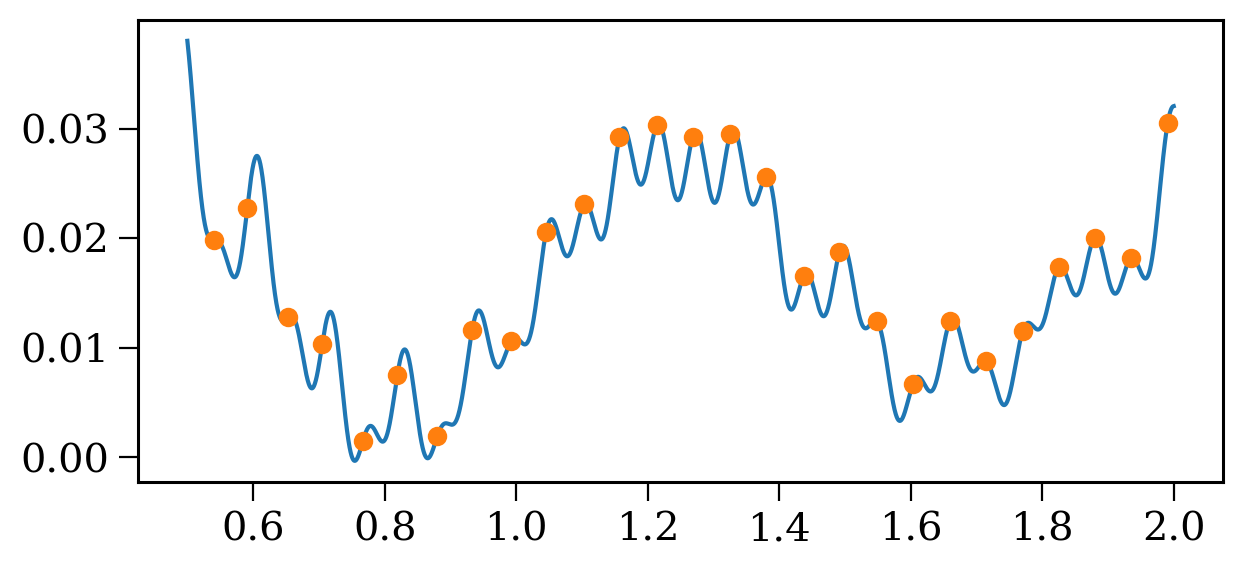

In [108]:
plt.figure(figsize=(7, 3))

P_range = np.linspace(0.5, 2.0, 5000)
plt.plot(P_range, [test(P * 86400) / 86400 for P in P_range])

ref_p = 1 / D_mix_tracks[1].freqs[141 - 1]["Re(freq)"].values

plt.scatter(ref_p, [test(P * 86400) / 86400 for P in ref_p], color="tab:orange", zorder=10)

3.508104

In [182]:
D_mix_tracks[1].history.loc[141 - 1]

model_number    1.410000e+02
star_age        2.103494e+08
star_mass       3.508104e+00
log_Teff        4.022240e+00
log_L           2.374201e+00
center_h1       1.051095e-01
center_he4      8.754308e-01
Name: 140, dtype: float64

In [185]:
10**(D_mix_tracks[1].profiles[141 - 1]["logR"].max())

4.626726871814766

In [201]:
def dimensionless_freqency(track, mod):
    M = track.history.loc[mod - 1]["star_mass"] * u.Msun
    R = 10**(track.profiles[mod - 1]["logR"].max()) * u.Rsun
    freqs = track.freqs[mod - 1]["Re(freq)"].values * u.day**(-1)
    sigma = np.sqrt((const.G * M / R**3)**(-1) * (2 * np.pi * freqs)**2)
    return sigma.to(u.dimensionless_unscaled).value

In [202]:
dimensionless_freqency(D_mix_tracks[1], 141)

array([0.30914921, 0.31808843, 0.32726992, 0.33727604, 0.34767546,
       0.35901766, 0.37085674, 0.38391511, 0.39743996, 0.41264237,
       0.42825812, 0.44598635, 0.46425089, 0.48519664, 0.50671248,
       0.53188942, 0.55756091, 0.58860441, 0.6201063 , 0.65965605,
       0.69922092, 0.75121051, 0.80234544, 0.87280558, 0.94207642,
       1.04130386, 1.13964638])

In [215]:
df_mt = D_mix_tracks[0].freqs[238 - 1][["Re(freq)", "n_g", "n_pg"]]
df_ref = D_mix_tracks[1].freqs[141 - 1][["Re(freq)", "n_g", "n_pg"]]

df_mt["dim_f"] = dimensionless_freqency(D_mix_tracks[0], 238)
df_ref["dim_f"] = dimensionless_freqency(D_mix_tracks[1], 141)

df = df_ref.merge(df_mt, on="n_pg", suffixes=("_ref", "_mt"))

/tmp/ipykernel_20697/1108639763.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mt["dim_f"] = dimensionless_freqency(D_mix_tracks[0], 238)
/tmp/ipykernel_20697/1108639763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref["dim_f"] = dimensionless_freqency(D_mix_tracks[1], 141)


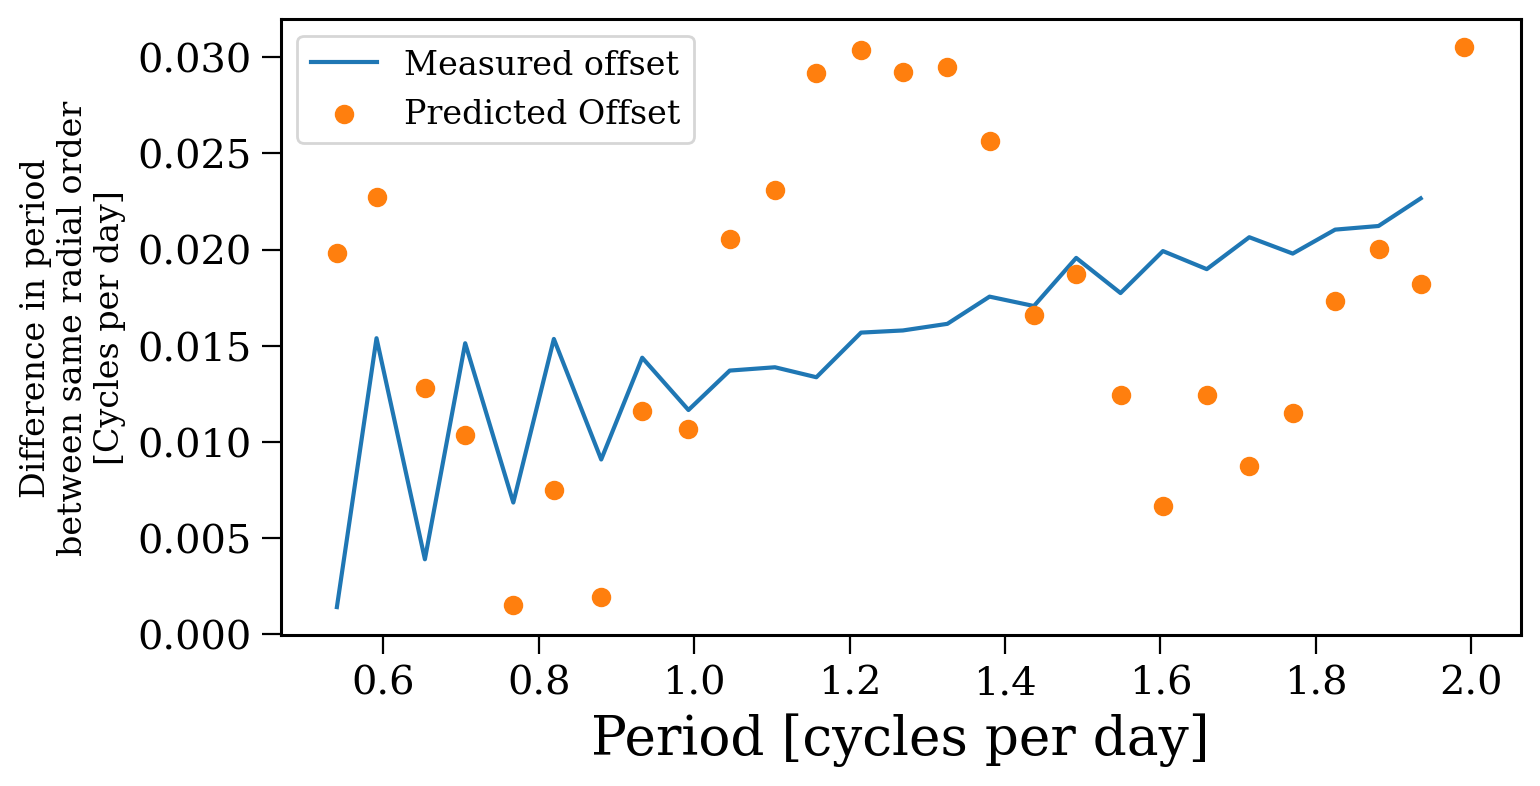

In [216]:
df["p_ref"] = 1 / df["Re(freq)_ref"]
df["p_mt"] = 1 / df["Re(freq)_mt"]
df = df.sort_values(by="p_ref")
df["offset"] = df["p_mt"] - df["p_ref"]

plt.figure(figsize=(8, 4))

plt.plot(df["p_ref"], df["offset"], label="Measured offset")
plt.scatter(ref_p, [test(P * 86400) / 86400 for P in ref_p], color="tab:orange", zorder=10, label="Predicted Offset")

plt.legend(fontsize=0.5*fs, loc="upper left")

plt.ylabel("Difference in period\nbetween same radial order\n[Cycles per day]", fontsize=0.5*fs)
plt.xlabel("Period [cycles per day]")

plt.show()
# df[["n_g", "offset"]]

In [222]:
[test(P) for P in df["dim_p_ref"].values]

[-4.449579872757089e-05,
 -5.3297184245857145e-05,
 -6.511588381288422e-05,
 -7.58619779164299e-05,
 -8.977106759381576e-05,
 -0.00010240845790683834,
 -0.00011820348590101564,
 -0.00013280792629477009,
 -0.00015028885559076173,
 -0.00016680613480107983,
 -0.0001858978495553931,
 -0.00020427549629637072,
 -0.00022507939426662327,
 -0.00024548408446520027,
 -0.00026813492155075715,
 -0.00029054653780456475,
 -0.00031509939968674236,
 -0.0003393994318579398,
 -0.00036586060478650297,
 -0.00039209224934686637,
 -0.000420190538240504,
 -0.0004483600868043099,
 -0.00047809085720800827,
 -0.0005080278318180513,
 -0.0005395680807823341,
 -0.0005711663590668095]

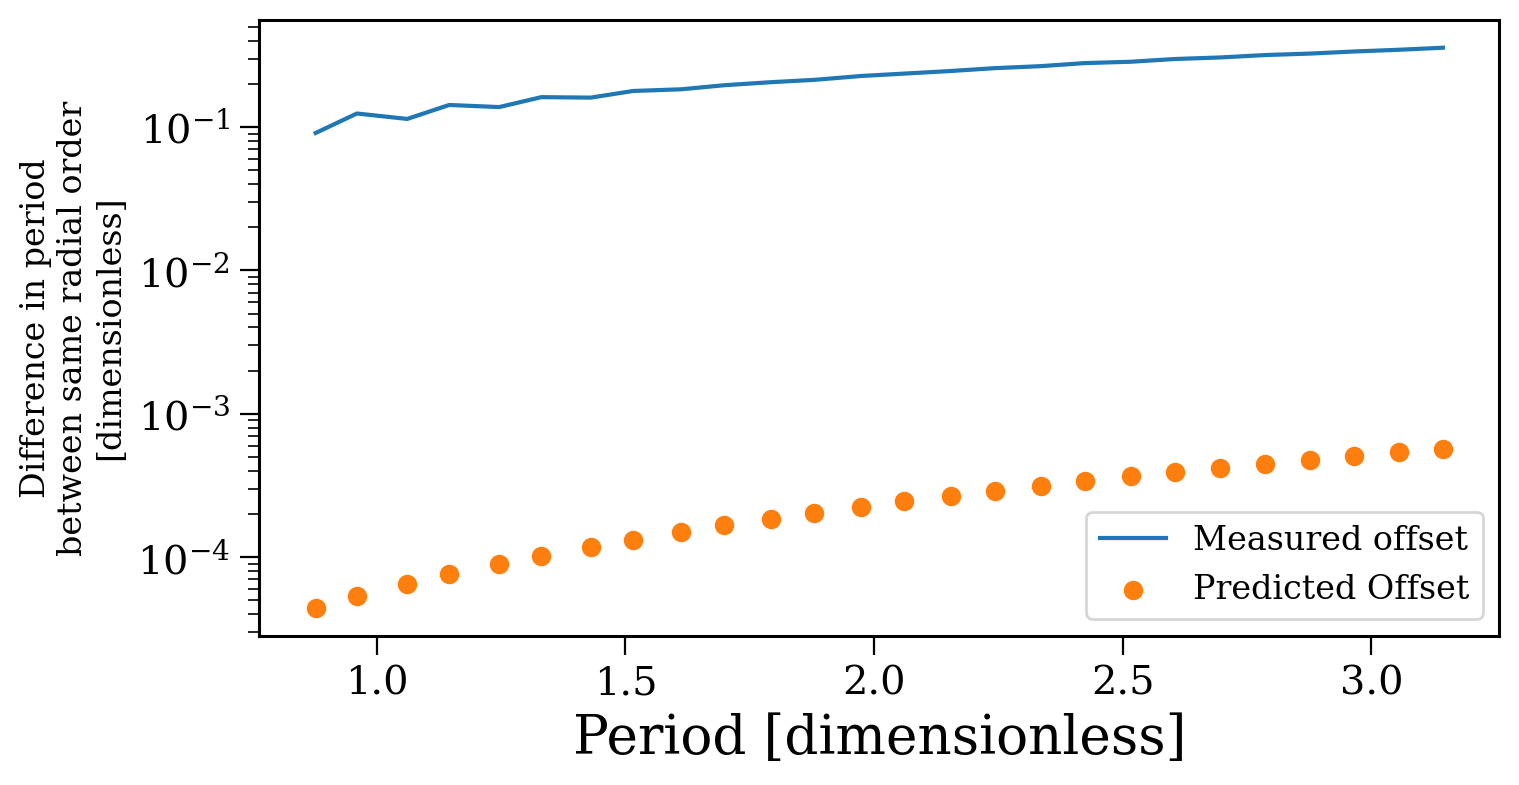

In [229]:
df["dim_p_ref"] = 1 / df["dim_f_ref"]
df["dim_p_mt"] = 1 / df["dim_f_mt"]
df = df.sort_values(by="dim_p_ref")
df["dim_offset"] = df["dim_p_mt"] - df["dim_p_ref"]

plt.figure(figsize=(8, 4))

plt.plot(df["dim_p_ref"], df["dim_offset"], label="Measured offset")
plt.scatter(df["dim_p_ref"], [-test(P) for P in df["dim_p_ref"].values], color="tab:orange", zorder=10, label="Predicted Offset")

plt.legend(fontsize=0.5*fs, loc="best")

plt.ylabel("Difference in period\nbetween same radial order\n[dimensionless]", fontsize=0.5*fs)
plt.xlabel("Period [dimensionless]")

plt.yscale("log")

plt.show()
# df[["n_g", "offset"]]

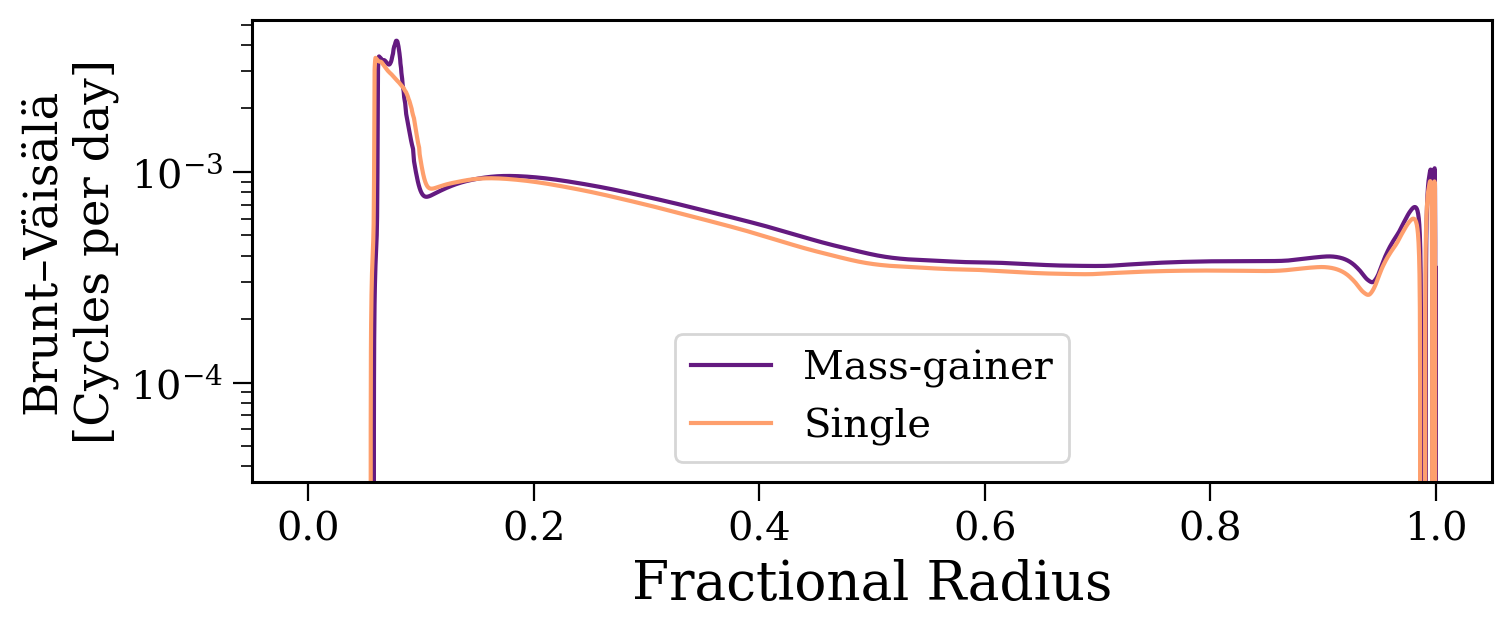

In [157]:
plt.figure(figsize=(8, 3))
for p, label, col in zip([D_mix_tracks[0].profiles[238 - 1], D_mix_tracks[1].profiles[141 - 1]],
                         ["Mass-gainer", "Single"], [plt.get_cmap("magma")(0.3), plt.get_cmap("magma")(0.8)]):
    plt.plot(10**(p["logR"]) / 10**(p["logR"].max()), p["brunt_N"], label=label, color=col)
    # plt.fill_between(10**(p["logR"]) / 10**(p["logR"].max()), p["brunt_N"], color=col, alpha=0.2)
plt.legend(loc="lower center")
plt.xlabel("Fractional Radius")
plt.ylabel("Brunt–Väisälä\n[Cycles per day]", fontsize=0.7 * fs)
plt.yscale("log")
plt.show()

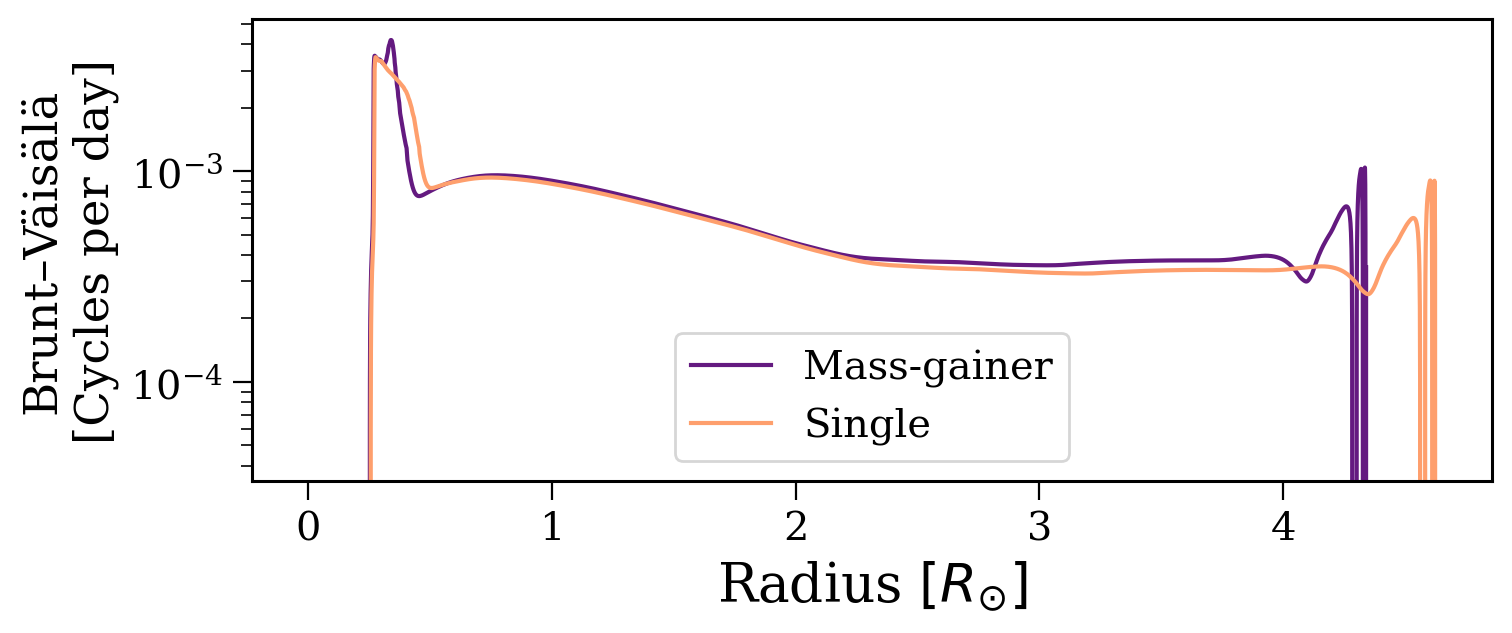

In [156]:
plt.figure(figsize=(8, 3))
for p, label, col in zip([D_mix_tracks[0].profiles[238 - 1], D_mix_tracks[1].profiles[141 - 1]],
                         ["Mass-gainer", "Single"], [plt.get_cmap("magma")(0.3), plt.get_cmap("magma")(0.8)]):
    plt.plot(10**(p["logR"]), p["brunt_N"], label=label, color=col)
plt.legend(loc="lower center")
plt.xlabel(r"Radius $[R_{\odot}]$")
plt.ylabel("Brunt–Väisälä\n[Cycles per day]", fontsize=0.7 * fs)
plt.yscale("log")
plt.show()

In [26]:
def interpolate_brunt_N(track, mod):
    p = track.profiles[mod - 1]
    r = 10**(p["logR"]) / 10**(p["logR"].max())
    m = p["mass"].values
    print(p["mass"][p["brunt_N"] > 0.0].min())
    print(r[p["brunt_N"] > 0.0].min())
    return interp1d(r, p["brunt_N"].values, bounds_error=False), interp1d(m, p["brunt_N"].values, bounds_error=False)

Plotting BV profile for X_c = 0.1


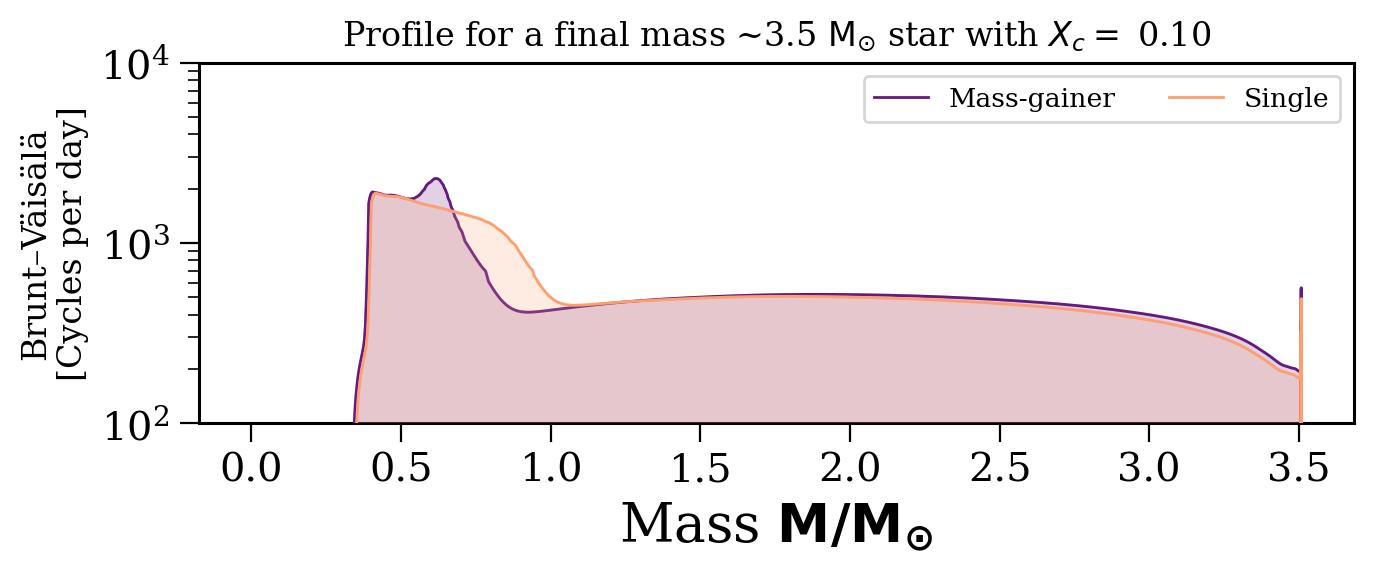

In [57]:
fig, ax = mesaplot.plot_BV_profile(X_c=0.1, tracks=D_mix_tracks, mt_index=0, ref_index=1, show=False)
ax.set_ylim(1e2, 1e4);

In [28]:
mt_brunt_r, mt_brunt_m = interpolate_brunt_N(D_mix_tracks[0], 238)
single_brunt_r, single_brunt_m = interpolate_brunt_N(D_mix_tracks[1], 141)

0.33903448842061296
0.058240390381147575
0.34679663399158867
0.055417635279060004


/tmp/ipykernel_8222/1180929855.py:11: RuntimeWarning: divide by zero encountered in divide
  dN_N = (mt_brunt_r(r_range) - single_brunt_r(r_range)) / single_brunt_r(r_range)
/tmp/ipykernel_8222/1180929855.py:11: RuntimeWarning: invalid value encountered in divide
  dN_N = (mt_brunt_r(r_range) - single_brunt_r(r_range)) / single_brunt_r(r_range)


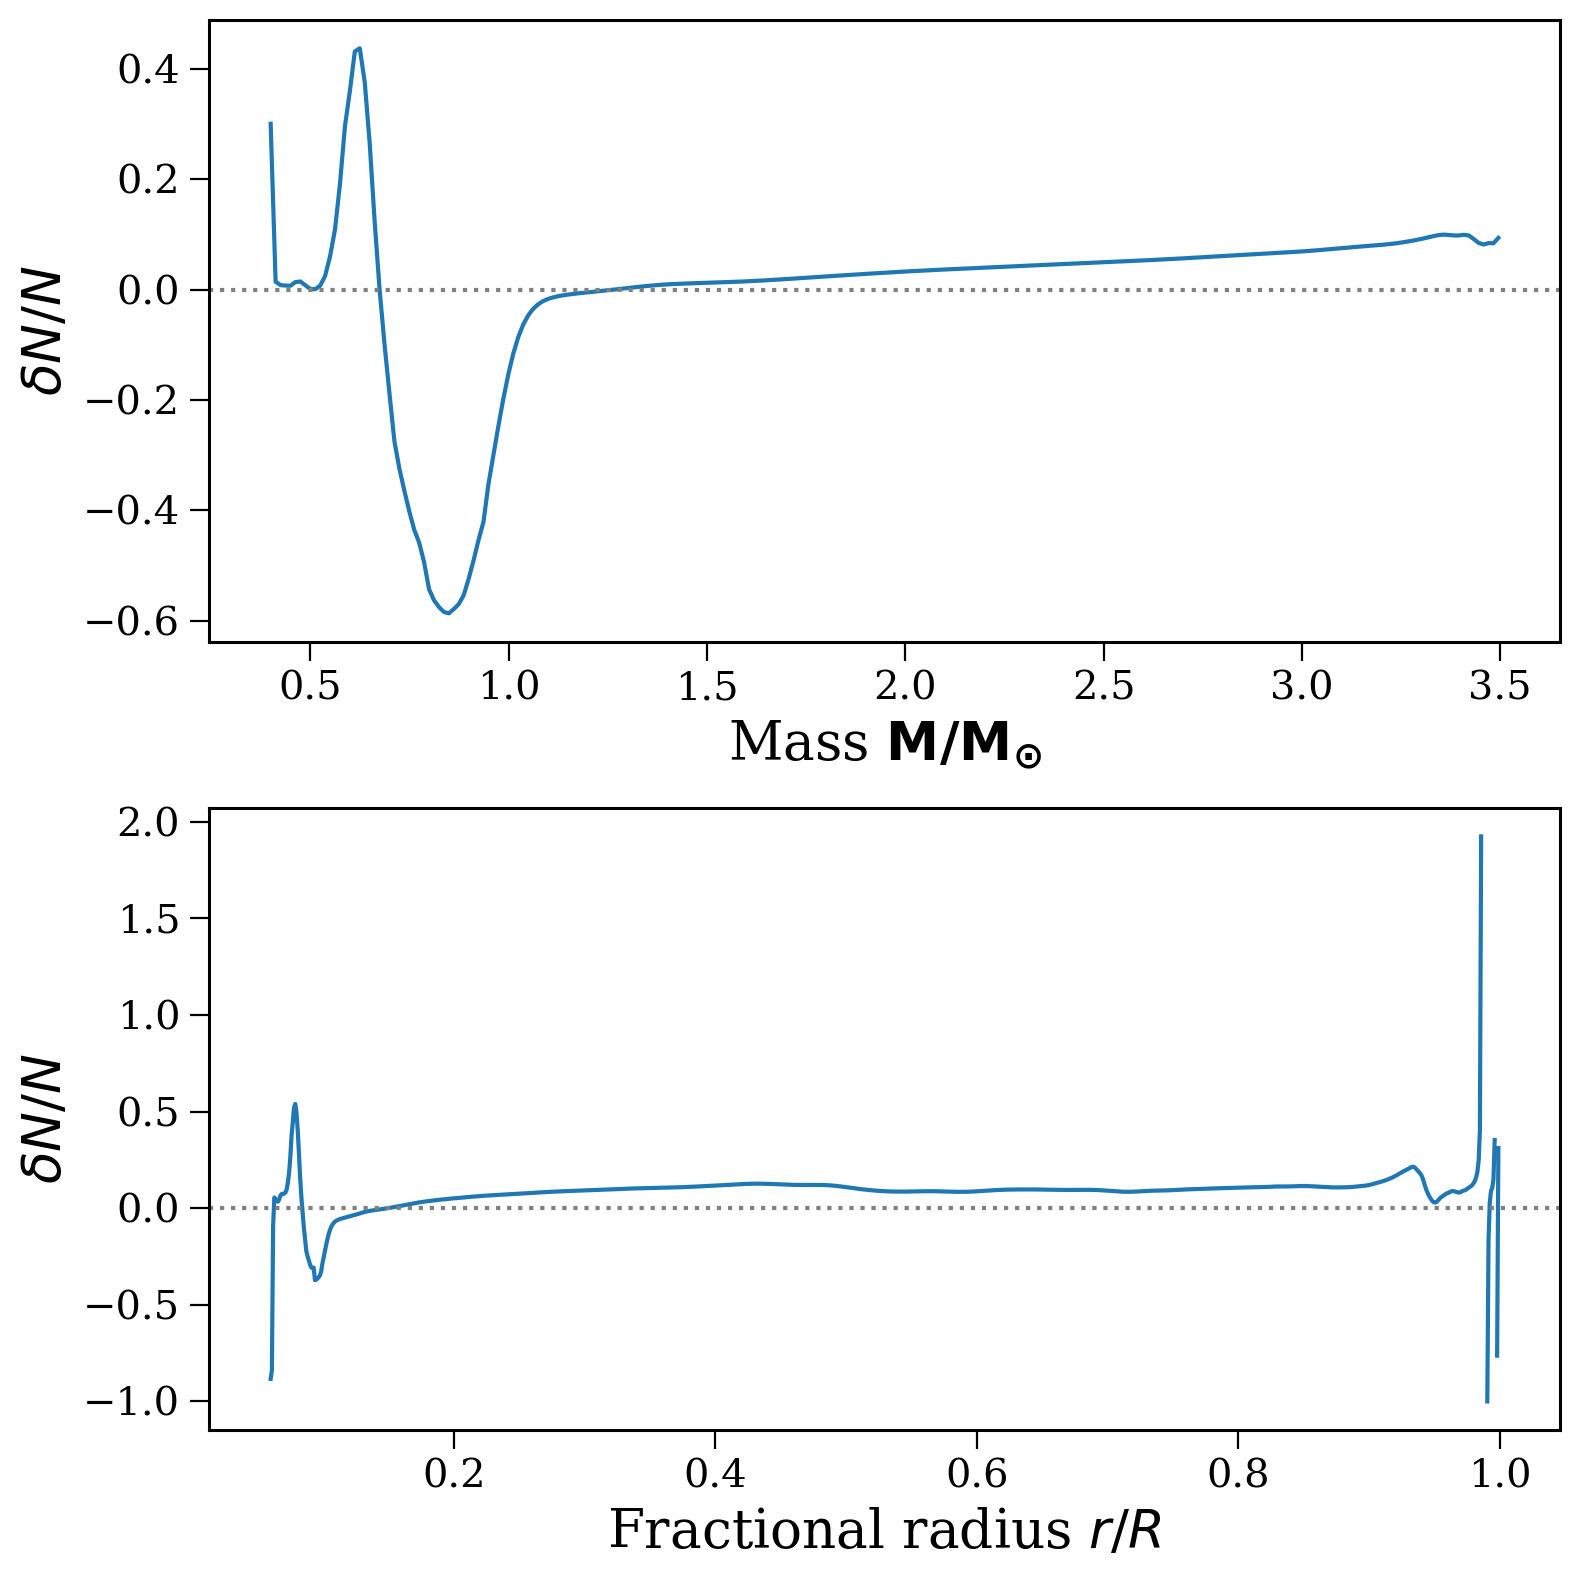

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

m_range = np.linspace(0.4, 3.508104, 250)
axes[0].plot(m_range, (mt_brunt_m(m_range) - single_brunt_m(m_range)) / single_brunt_m(m_range))
axes[0].set_xlabel(r"Mass $\mathbf{M/M_{\odot}}$")
axes[0].set_ylabel(r"$\delta N / N$")
axes[0].axhline(0, linestyle="dotted", color="grey")

r_range = np.linspace(0.06, 1, 1000)

dN_N = (mt_brunt_r(r_range) - single_brunt_r(r_range)) / single_brunt_r(r_range)
axes[1].plot(r_range, dN_N)
axes[1].set_xlabel(r"Fractional radius $r/R$")
axes[1].set_ylabel(r"$\delta N / N$")
axes[1].axhline(0, linestyle="dotted", color="grey")

plt.tight_layout()

plt.show()

In [26]:
r_lim = 0.98
np.trapz(y=np.nan_to_num(dN_N[r_range < r_lim]), x=r_range[r_range < r_lim])

NameError: name 'dN_N' is not defined

In [49]:
boundary_edge_range = np.linspace(core_boundary(D_mix_tracks[1], 141), r_lim, 1000)

In [53]:
pi0

0.0005448340638286466

In [242]:
from tomso import gyre

In [246]:
x = gyre.load_gyre("../output/mass_transfer_grid_with_D_mix/M_3-MT_0.4/LOGS/profile238.data.GYRE")

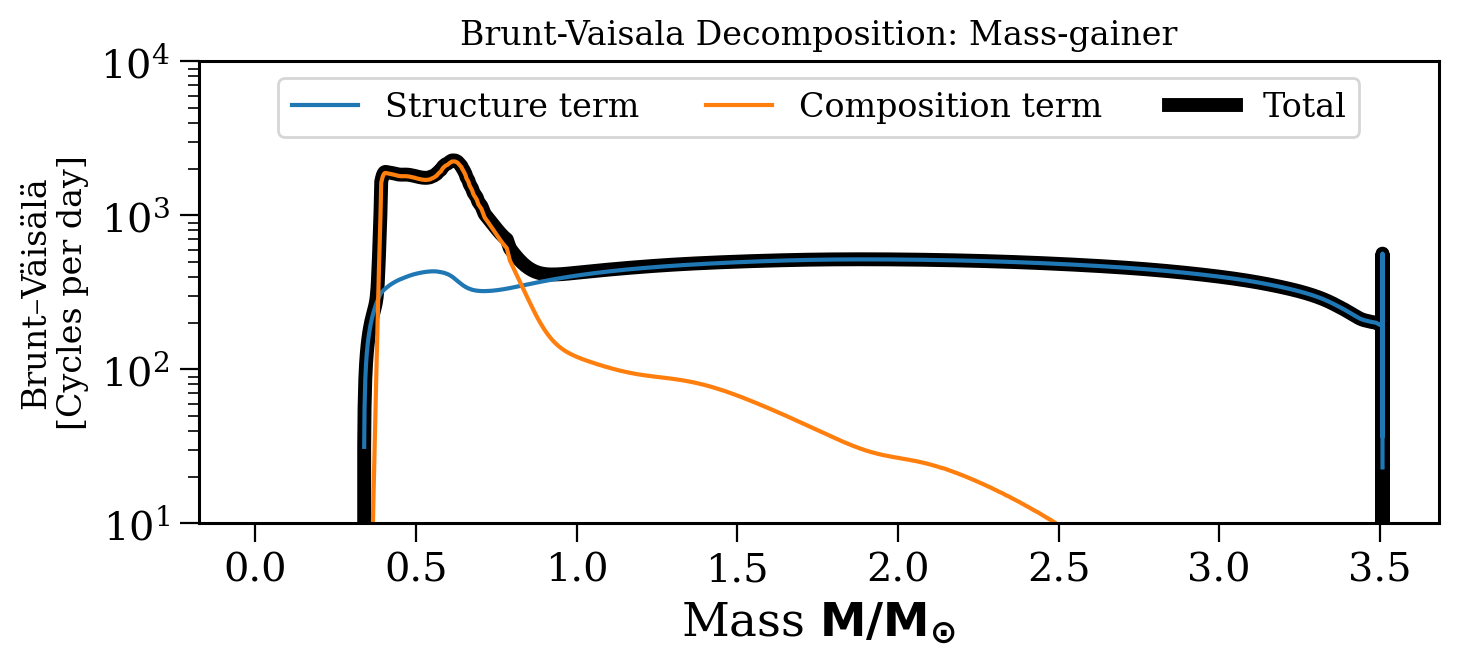

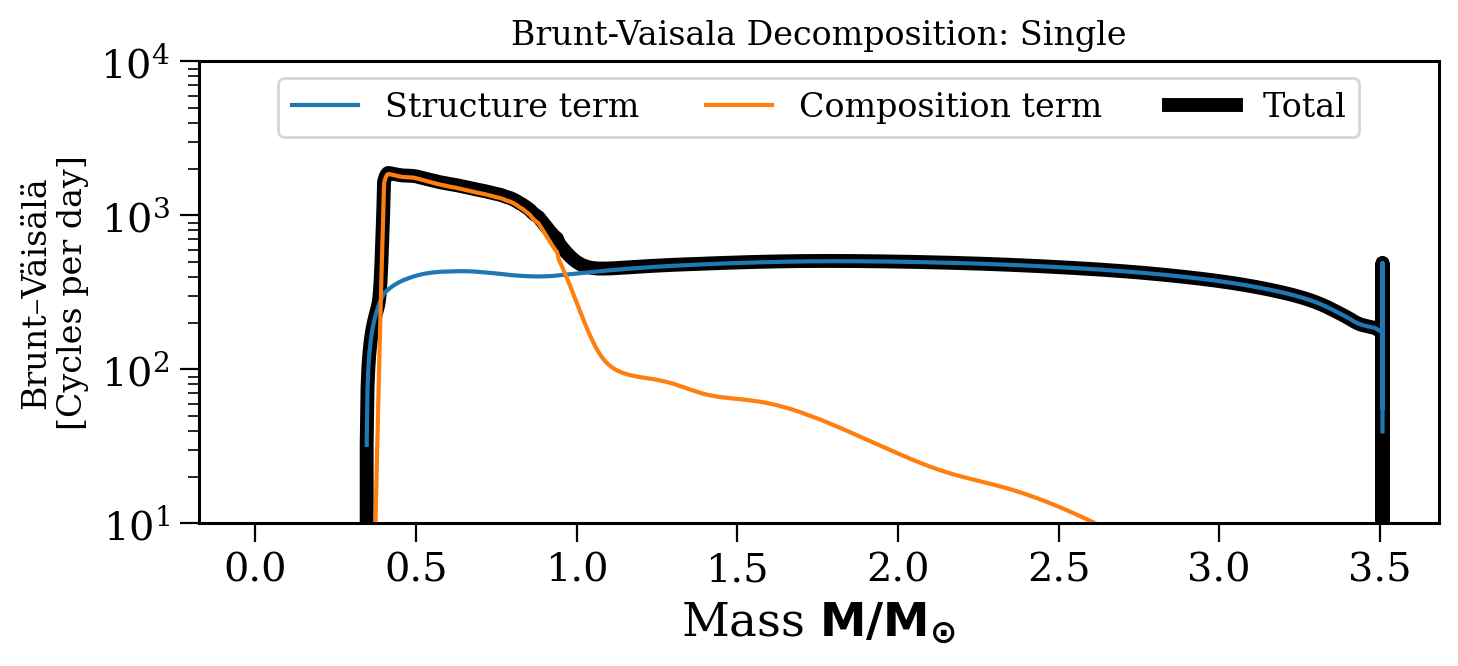

In [290]:
fac = ((2 * np.pi * u.Hz).to(u.day**(-1))).value


for p, label in zip([D_mix_tracks[0].profiles[238 - 1], D_mix_tracks[1].profiles[141 - 1]],
                    ["Mass-gainer", "Single"]):
    plt.figure(figsize=(8, 3))
    plt.plot(p["mass"], p["brunt_N2_structure_term"]**(0.5) * fac, label="Structure term")
    plt.plot(p["mass"], p["brunt_N2_composition_term"]**(0.5) * fac, label="Composition term")
    plt.plot(p["mass"], p["brunt_N"] * fac, color="black", lw=5, zorder=-1, label="Total")
    
    plt.yscale("log")
    plt.ylim(1e1, 1e4)
    
    plt.legend(ncols=3, fontsize=0.5*fs, loc="upper center")
    plt.title(f"Brunt-Vaisala Decomposition: {label}")
    
    plt.ylabel("Brunt–Väisälä\n[Cycles per day]", fontsize=0.5 * fs)
    plt.xlabel(r"Mass $\mathbf{M/M_{\odot}}$", fontsize=0.7 * fs)
    plt.show()

# Binaries

In [126]:
pd.read_fwf("../binary_template/LOGS_binary/binary_history.data", skiprows=5)

,model_number,age,period_days,binary_separation,v_orb_1,v_orb_2,rl_1,rl_2,rl_relative_overflow_1,rl_relative_overflow_2,...,J_orb,Jdot,jdot_mb,jdot_gr,jdot_ml,jdot_ls,jdot_missing_wind,extra_jdot,donor_index,point_mass_index
0,5,2.325500e+04,5.000000,23.538772,102.076354,136.101805,9.510942,8.339862,-0.750432,-0.756381,...,1.329526e+53,-9.593217e+32,0.0,-9.593217e+32,0.0,0.0,0.0,0.0,1,0
1,10,8.112088e+04,5.000000,23.538771,102.076355,136.101807,9.510942,8.339862,-0.752520,-0.757763,...,1.329526e+53,-9.593218e+32,0.0,-9.593218e+32,0.0,0.0,0.0,0.0,1,0
2,15,2.251097e+05,4.999999,23.538770,102.076359,136.101811,9.510941,8.339861,-0.753314,-0.758668,...,1.329526e+53,-9.593220e+32,0.0,-9.593220e+32,0.0,0.0,0.0,0.0,1,0
3,20,5.834000e+05,4.999998,23.538766,102.076367,136.101823,9.510940,8.339860,-0.753467,-0.759320,...,1.329526e+53,-9.593224e+32,0.0,-9.593224e+32,0.0,0.0,0.0,0.0,1,0
4,25,1.474941e+06,4.999995,23.538756,102.076388,136.101850,9.510936,8.339857,-0.753097,-0.759625,...,1.329526e+53,-9.593236e+32,0.0,-9.593236e+32,0.0,0.0,0.0,0.0,1,0
5,30,3.693380e+06,4.999987,23.538733,102.076439,136.101919,9.510926,8.339848,-0.751259,-0.759244,...,1.329525e+53,-9.593264e+32,0.0,-9.593264e+32,0.0,0.0,0.0,0.0,1,0
6,35,9.213566e+06,4.999969,23.538673,102.076567,136.102090,9.510902,8.339827,-0.746464,-0.757261,...,1.329523e+53,-9.593334e+32,0.0,-9.593334e+32,0.0,0.0,0.0,0.0,1,0
7,40,1.931305e+07,4.999934,23.538565,102.076802,136.102403,9.510859,8.339789,-0.738170,-0.753381,...,1.329520e+53,-9.593479e+32,0.0,-9.593479e+32,0.0,0.0,0.0,0.0,1,0
8,45,3.099673e+07,4.999894,23.538440,102.077074,136.102765,9.510808,8.339744,-0.728632,-0.748981,...,1.329517e+53,-9.593654e+32,0.0,-9.593654e+32,0.0,0.0,0.0,0.0,1,0
9,50,4.313543e+07,4.999853,23.538310,102.077356,136.103141,9.510755,8.339698,-0.718159,-0.744460,...,1.329513e+53,-9.593839e+32,0.0,-9.593839e+32,0.0,0.0,0.0,0.0,1,0
